# _**Agglomerative_classifier**_   

__<u>Agglomerative Clustering</u>__  
 — это иерархический метод кластеризации, который объединяет объекты снизу вверх:  
1️⃣ Начинаем с каждого объекта как отдельного кластера.  
2️⃣ Постепенно объединяем самые близкие кластеры.  
3️⃣ Повторяем, пока не останется только нужное количество кластеров (или пока расстояние между кластерами не превысит порог).  

__Когда применять Agglomerative Clustering?__  
✔ Если количество кластеров неизвестно – можно использовать distance_threshold.  
✔ Если данные имеют сложные формы кластеров.  
✔ Если хочется визуализировать процесс кластеризации (дендрограмму).  

Недостатки:  
❌ Медленный на больших данных (O(n²) или даже O(n³)).  
❌ Не умеет выделять "шум" (в отличие от HDBSCAN).  

# <font color='yellow'>->_pip, import_

#### <font color='yellow'>_Импорты_

In [ ]:
!pip install transformers[sentencepiece]
!pip install -U sentence-transformers
!pip install huggingface_hub
!pip install tqdm

In [2]:
import torch
from sentence_transformers import SentenceTransformer

In [3]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Кластеризатор
from sklearn.cluster import AgglomerativeClustering

#### <font color='yellow'>_Работа локально_

In [ ]:
!pip install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv

# Проверка
load_dotenv()
print(os.getenv("HF_TOKEN"))

# Использования токена:
from huggingface_hub import login
login(os.getenv("HF_TOKEN"))

# Подключение файла classifiers_functions.py (классификаторы и ф-ция оценки качества классификации)
sys.path.append('./Classifiers')
ımport classifiers_functions

#### <font color='yellow'>_Работа на Google Colab_

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
# Связь с файлами на Google drıve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='lightblue'>-> _кластеризация по сохраненным эмбеддингам_

### _загрузка текстов и их эмбеддингов <font color='orange'><small>(all_texts, ebeddings)_  

In [ ]:
# Если не было ранее подключение в google drive
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# Загрузка текстов

# _______ Параметры ______________
chunk_size = 1000 # # Размер чанка при загрузке текстов
# Google Colab
file_path_data = '/content/drive/My Drive/Example_ML/classification_text/Classifiers/articles.csv'
# Локально
# file_path_data = 'articles.csv'
text_column = "title"  # Название колонки с текстами

# _________ Загрузка _______________________

all_texts = []
max_text = 5000 # maximum number of texts !!! Используется в названии файла !!!
current_count = 0

for chunk in tqdm(pd.read_csv(file_path_data, chunksize=chunk_size), desc="Обработка данных"):
    if text_column not in chunk.columns:
        print(f"Ошибка: в CSV нет колонки '{text_column}'. Доступные: {chunk.columns}")
        break

    texts = chunk[text_column].dropna().tolist()  # Убираем пустые значения

    remaining = max_text - current_count
    if remaining <= 0:
        break
    # Обрезаем чанк, если он превышает лимит
    if len(texts) > remaining:
        texts = texts[:remaining]
    all_texts.extend(texts)  # Объединяем части текста вместе

    current_count += len(texts)
    if current_count >= max_text:
        break

len(all_texts) # list

Обработка данных: 4it [00:00,  6.35it/s]


5000

In [7]:
# Загрузка эмбеддингов

# _________ Параметры ____________
batch_size = 1000  # Размер батча

# Google Colab
file_path_embeddings = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/embeddings_rubert-tiny2_text_{max_text}.npy'  # Путь к файлу эмбеддингов
# Локально
# file_path_embeddings = './Data/embeddings_rubert-tiny2.npy'  # Файл с эмбеддингами

# _________ Загрузка _______________________
# Загружаем файл в режиме "чтение без загрузки в память"
embeddings_mmap = np.load(file_path_embeddings, mmap_mode="r")

num_samples = embeddings_mmap.shape[0] # Определяем количество примеров (должно быть = max_text)
all_embeddings = [] # Пустой список для хранения частей эмбеддингов

# Читаем файл частями
for i in range(0, num_samples, batch_size):
    batch = embeddings_mmap[i : i + batch_size]  # Загружаем батч
    all_embeddings.append(batch)  # Добавляем в список

embeddings = np.vstack(all_embeddings) # Объединяем все части в один массив NumPy

print(f"Форма объединённого массива: {embeddings.shape}") # Проверяем размер итогового массива

Форма объединённого массива: (5000, 312)


### _анализ данных_ <font color='orange'><small>(дендрограмма, среднее расстояние между точками, проверка эмбеддингов (нормализация)</small>).

In [ ]:
# _________Построением дендрограммы_________
# 📌 Позволяет прикинуть, на сколько классов целесообразно разбить данные.
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(10, 5))
sch.dendrogram(sch.linkage(embeddings[:100], method='average', metric='cosine'))

# Добавляем горизонтальную линию на уровне ...
plt.axhline(y=0.26, color='r', linestyle='--')  # Порог для разбиения

plt.show()

In [ ]:
# _________Среднее расстояние между точками.___________
# 📌 Для DBSCAN это дает ориентир для выбора значения `eps` - параметра окна, в котором подсчитывается число "соседних" точек.
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5) #  ищем 5 ближайших соседей для каждой точки.
neighbors.fit(embeddings)                   #  "запоминаем" точки эмбеддингов в алгоритме ближайших соседей.
#  вычисляем расстояния до n_neighbors ближайших точек.
distances, _ = neighbors.kneighbors(embeddings)
avg_distance = np.mean(distances[:, -1])  # Среднее расстояние до 5-го соседа
print(f"Среднее расстояние между точками: {avg_distance:.4f}")
# Среднее расстояние между точками: 0.4798

Среднее расстояние между выбранным количеством соседних точкек: 0.4798


<small>Что делает `distances, _ = neighbors.kneighbors(embeddings)`  
В distances[i, j] хранится расстояние от i-го эмбеддинга текста до его j-го ближайшего соседа. Пример: distances[:]  
```
array([
    [0.00, 0.32, 0.45, 0.51, 0.67],  # 5 соседей для 1-го эмбеддинга текста
    [0.00, 0.28, 0.41, 0.55, 0.70],  # 5 соседей для 2-го эмбеддингатекста
    ...
    [0.00, 0.30, 0.49, 0.60, 0.80]   # 5 соседей для 27000-го эмбеддинга текста
])
```
distances[i, -1] — расстояние до самого дальнего из 5 соседей.</small>

In [ ]:
# Нормализация эмбеддингов (проверка)
norms = np.linalg.norm(embeddings, axis=1) # Вычислим нормы всех эмбеддингов

print(f"Min norm: {np.min(norms)}")
print(f"Max norm: {np.max(norms)}")
print(f"Mean norm: {np.mean(norms)}")

### _кластеризация_

In [8]:
# Количественное распределение текстов по кластерам:
from collections import Counter

In [9]:
# Кластеризация
model = AgglomerativeClustering(
                                n_clusters=10,
                                # distance_threshold=4.8,  # Порог объединения
                                metric ='cosine',
                                linkage='complete'
                                )

##### 📌 Ключевые параметры:

- `n_clusters` – сколько кластеров нужно (можно не указывать и задать `distance_threshold` вместо этого).
- `affinity` – как измерять расстояние между точками ("cosine", "euclidean" и др.).  
- `linkage` – как считать расстояние между кластерами:  

    1. _"single"_ – ближайшие точки (может давать вытянутые кластеры).  
    🔹 Как работает?  
      Расстояние между кластерами = минимальное расстояние между их точками.  
      🔹 Плюсы:  
      ✅ Хорошо находит длинные цепочки точек (используется в детекции контуров)  
      ✅ Может выявить неявные связи между объектами  
      🔹 Минусы:  
      ❌ Очень чувствителен к шуму и выбросам  
      ❌ Может создавать длинные, некомпактные кластеры  
      🔹 Когда использовать?  
      ✔ Когда важны связи между соседними точками, например, в географических  данных или графах.  

    2. _"complete"_ – самые дальние точки (более плотные кластеры).  
    🔹 Как работает?  
      Расстояние между кластерами = максимальное расстояние между их точками.  
      🔹 Плюсы:  
      ✅ Предпочитает компактные, четко отделённые кластеры  
      ✅ Менее чувствителен к выбросам, чем single  
      🔹 Минусы:  
      ❌ Иногда приводит к длинным "цепочкам" кластеров  
      ❌ Могут появляться разрозненные и вытянутые кластеры  
      🔹 Когда использовать?  
      ✔ Подходит для чётко разделённых групп (например, если данные имеют  плотные группы точек).  

    3. _"average"_ – среднее расстояние (баланс).  
    🔹 Как работает?  
        Расстояние между кластерами = среднее расстояние между всеми парами точек   (по одной точке из каждого кластера).  
        🔹 Плюсы:  
        ✅ Подходит для кластера любой формы  
        ✅ Более устойчив к шуму, чем complete  
        🔹 Минусы:  
        ❌ Может давать менее чёткие границы между кластерами  
        🔹 Когда использовать?  
        ✔ Хороший универсальный вариант, если данные не идеально подходят под  ward или complete.  

    4. _"ward"_ – минимизирует дисперсию (только с affinity="euclidean").
    🔹 Как работает?  
        _Оценивает изменение дисперсии при объединении кластеров. Выбирает два    кластера, при объединении которых увеличение суммарной дисперсии будет    минимальным.__  
        🔹 Плюсы:  
        ✅ Хорошо работает на евклидовых расстояниях  
        ✅ Обычно даёт сбалансированные и плотные кластеры  
        🔹 Минусы:  
        ❌ Требует евклидовой метрики (metric="euclidean")  
        ❌ Может плохо работать, если данные содержат шум или выбросы  
        🔹 Когда использовать?  
        ✔ Подходит для компактных, сферических кластеров (как в K-Means)   

##### Далее...

In [10]:
# Получаем метки кластеров
clusters = model.fit_predict(embeddings)
# print(set(clusters)) # Количество кластеров
num_clusters = len(set(clusters))
print(f"✅ Форма clusters - {clusters.shape}")
print(f"✅ Количество clusters {num_clusters}")
counts_cluster = Counter(clusters) # Количественное распределение текстов по кластерам:
counts_cluster

✅ Форма clusters - (5000,)
✅ Количество clusters 10


Counter({np.int64(9): 347,
         np.int64(4): 226,
         np.int64(7): 227,
         np.int64(3): 1713,
         np.int64(5): 411,
         np.int64(6): 240,
         np.int64(8): 340,
         np.int64(1): 371,
         np.int64(0): 922,
         np.int64(2): 203})

In [11]:
# Формируем датафрейм их текстов, их эмбеддингов и меток
df = pd.DataFrame({"text": all_texts, "embedding": list(embeddings), "cluster": list(clusters)})
df.head()

,text,embedding,cluster
0,Заместитель председателяnправительства РФnСерг...,"[0.07518719, -0.0055617844, 0.014240301, -0.04...",9
1,Матч 1/16 финала Кубка России по футболу был п...,"[0.00035189706, -0.04810312, -0.020328153, -0....",4
2,Форвард «Авангарда» Томаш Заборский прокоммент...,"[0.04424202, 0.00478189, -0.02290487, -0.04921...",7
3,Главный тренер «Кубани» Юрий Красножан прокомм...,"[0.047330584, 0.031060353, 0.0015447184, -0.03...",3
4,Решением попечительского совета владивостокско...,"[0.07092083, -0.05181958, -0.01780495, -0.0265...",9


In [12]:
# Просмотр релевантности текстов в кластерах определенным темам
claster_number = 3 # Выбор номера кластера
df_filtered =  df[df["cluster"] == claster_number] # Фильтруем строки
print(df_filtered['text'].tail(10)) # Выводим первые 10 строк

2971    Президент Всероссийской Федерации легкой атлет...
2981    Нападающий Владимир Дядюн, сменивший казанский...
2982    Трехкратный чемпион мира в беге на 100 метров ...
2984    Глава команды «Заубер» Мониша Кальтенборн заяв...
2988    Президент «Динамо» Геннадий Соловьев прокоммен...
2998    Президент СКА Геннадий Тимченко прокомментиров...
2999    Казанский «Рубин» и московское «Динамо» соглас...
3253    Президент России Владимир Путин на встрече с р...
4096    Вдова Ясира Арафата заявила, что жалеет о брак...
4410    Председатель Совета федерации Валентина Матвие...
Name: text, dtype: object


### _сохранение (тексты, эмбеддинги, метки)_

In [13]:
# Google Colab
output_file = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_AgglCl_{max_text}.csv'
# Локально
# output_file = f"./Data/clusters_rubert-tiny2_KMeans_{max_text}.csv"

df.to_csv(output_file, index=False, encoding="utf-8")
print(f"✅ Кластеры сохранены в {output_file}.")

✅ Кластеры сохранены в /content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_AgglCl_5000.csv.


## <font color='lightgreen'>_-> Визуализация кластеров_</font>

In [14]:
# Признаки (эмбеддинги)
X_old = np.stack(df['embedding'].to_numpy()) # Преобразуем списка с эмбеддингами в массив чисел
# Метки
y_old = df['cluster']

print(X_old.shape, X_old.dtype) # Должно быть (количество образцов, размерность эмбеддинга) Должно быть float32 или float64
print(y_old.shape, y_old.dtype) # Должно быть (количество образцов, ) Должно быть int64

(5000, 312) float32
(5000,) int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


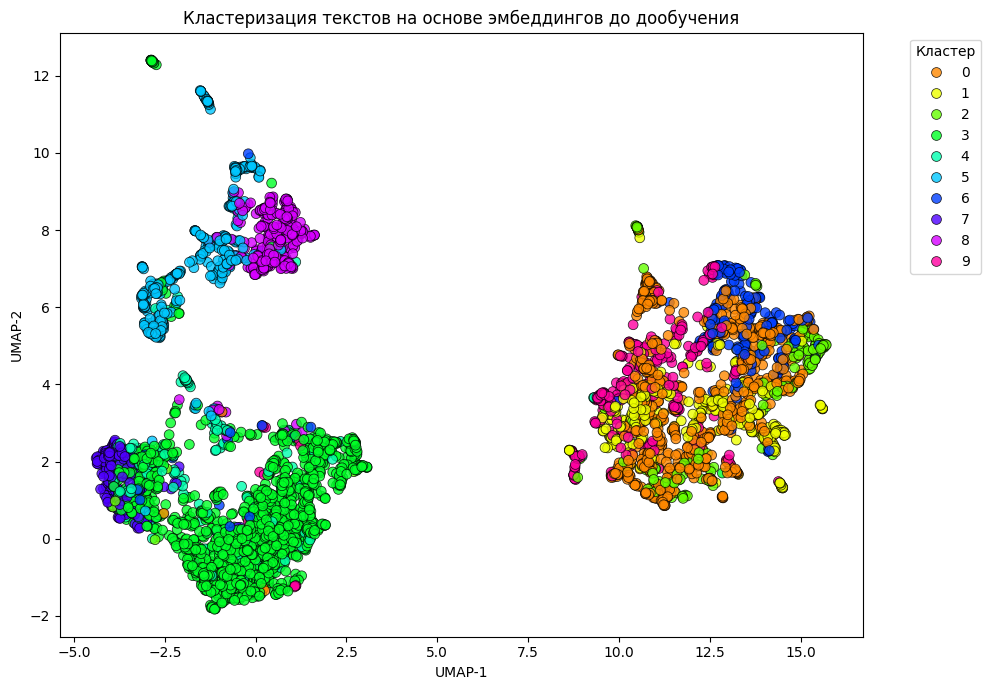

In [15]:
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import pandas as pd

# 1. UMAP проекция
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='cosine', random_state=42) # n_neighbors=15	Сколько ближайших соседей учитывать	(влияет на "локальность" — чем меньше, тем сильнее UMAP фокусируется на локальной структуре),  min_dist=0.1	Минимальная допустимая дистанция между точками (в низкомерном пространстве	чем меньше, тем плотнее группы), metric='cosine'	Метрика расстояния	(cosine лучше работает с эмбеддингами, чем euclidean)
embeddings_2d = reducer.fit_transform(X_old)

# 2. Подготовка DataFrame для визуализации
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': y_old
})
# Визуализация
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(set(y_old)))
sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette=palette, s=50, alpha=0.8, edgecolor='k')
plt.title("Кластеризация текстов на основе эмбеддингов до дообучения")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()